# Salish Sea cruise data from 2008-2024

## Regression of pH vs dissolved oxygen and other variables

Regression of Salish Sea pH vs dissolved oxygen (DO), and other selected variables, using data from Alin et al 2024 (https://bg.copernicus.org/articles/21/1639/2024/ and https://essd.copernicus.org/articles/16/837/2024/)

Updated to also include data through 2024 and basin categories in the following csv file received from Simone Alin on 7/28/2025 (update of landing page https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/SalishCruise_DataPackage.html):

- SalishCruise_seacarb_2008to2024_07232025_basins.csv

### Methods

The response variable for the regression analysis was pH_total_Lueker.

The candidate features for predictor variables were oxygen, salinity, temperature, pressure, and month of sample collection

The regression analysis was performed using the following six machine learning methods with cross-validated optimization:

1) XGBoost XGBRegressor
2) CatBoost Regressor
3) Support Vector Regression (SVR)
4) K-Nearest Neighbors (KNN) regression
5) Lasso regression
6) Stepwise linear regression to minimize Bayesian Information Criterion

Each of the regression methods used the following three-step cross-validation approach:

- a. train the model using 80% of the data
- b. test the trained model using the other 20% of the data
- c. final fit of the model using 100% of the data with the selected features and hyperparameters from  the training step (a)

In addition to separating the data into train and test subsets (a) and (b), the train step (a) was performed using repeated K-fold cross-validation for optimization of hyperparameters and feature selection for machine learning methods 1-5.

For regression  methods 1-5 the continuous features (oxygen, salinity, temperature, pressure) were scaled with StandardScaler because of the requirements of these methods for standardized features. For method 6 the continuous features were not scaled because it is not required for linear regression, and the results are more easily interpreted without scaling. 

The months of sample collection were one-hot encoded as categorical dummy variables for all methods (i.e. each month number 1-12 was assigned as a separate dummy feature with values of 0 or 1, where 1 indicates that the sample was collected in that month). The seven numerical basin categories (1=coast, 2=SJDF, 3=AR, 4=MB, 5=SS, 6=WB, 7=HC) were also one-hot encoded as separate dummy variables for each basin in the same manner as the months.

Adding sigma-theta to the list of candidate features was also tried, but there is too much multicollinearity between salinity and sigma-theta. Therefore, salinity was selected, and sigma-theta was not included as a candidate feature.

The model skill metrics (e.g. R-squared, RMSE, etc) from step (b) provide the best estimate of how well the model is expected to perform on new data. Special care was taken in all steps of the analysis to ensure that there is no data leakage between the train (a) and test (b) subsets so that the test subset is considered to be completely independent of the model training.

### Summary of results

The analysis below presents the results for each method individually, and then follows with a summary section to compare the results of all methods. Table 1 in the summary section shows that the Support Vector Regression (SVR) method has the best model skill (test model R-squared 0.9096 and RMSE=0.0629 pH units). The stepwise regression results have the lowest model skill (test model R-squared 0.8762 and RMSE=0.0736 pH units), but are still fairly good, explainining about 88% of the variability in pH, and are more easily interpreted and applied compared with the machine learning methods. The summary section below also shows QQ plots for pH predictions from each regression method, showing that the predictions align closely with the observations. This shows that all of the methods have good skill for representing the distribution of observations.

### PyMLR

The regression analysis was applied using the PyMLR module. Before running this notebook, first install the PyMLR module in your environment using the following line:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read the carbonate systen  dataset for the Salish Sea into a pandas dataframe

Next we will read the dataset that includes 6527 observations of pH in the Salish Sea from 2008-2024

In [3]:
# fn = 'SalishCruises_2008to2018_MeasCalcParamsToNCEI_12162024.csv'
fn = 'SalishCruise_seacarb_2008to2024_07232025_basins.csv'   # email from Simone Alin 7/29/2025
df = pd.read_csv(fn)

### Show the data types in the dataframe

Shown below are the following properties for each column of the dataframe:

- dtype
- nunique: number of unique values
- isna_sum: number of missing values (nan or None)
- zero_sum: sum of all the values in the column that are equal to zero
- one_sum: sum of all the values in the column that are equal to one

In [4]:
def show_dtypes(df):
    '''
    Show the dtype and number of unique values for each column of a dataframe
    Arg:
        df: dataframe to be examined
    Returns transposed dataframe of each feature, dtype, and number of unique values    
    '''
    import pandas as pd    
    # Display dtype and number of unique values for each column
    # result = df.apply(lambda col: pd.Series({'dtype': col.dtype, 'unique_values': col.nunique()}))
    result = df.apply(lambda col: pd.Series({'dtype': col.dtype, 
                                             'nunique': col.nunique(),
                                             'isna_sum': col.isna().sum()
                                             # 'zero_sum': (col == 0).sum(),
                                             # 'one_sum': (col == 1).sum()
                                            }))    
    with pd.option_context('display.max_rows', None):
        print(result.T)
    return result.T

In [5]:
# from PyMLR import show_dtypes
df_dtypes = show_dtypes(df)

                                              dtype nunique isna_sum
Unnamed: 0                                    int64    6527        0
RECORD                                        int64    6527        0
EXPOCODE                                     object      45        0
CRUISE_ID                                    object      59        0
DATE_UTC                                     object     248        0
TIME_UTC                                     object    5302        0
DATE_LOCAL                                   object     243        0
TIME_LOCAL                                   object    5634        0
LONGITUDE_DEC                               float64    1623        0
LATITUDE_DEC                                float64    1657        0
STATION_NO                                    int64      50        0
NISKIN_NO                                     int64      24        0
NISKIN_NO_FLAG_W                              int64       3        0
MONTH_UTC                         

### Map of stations with basin category numbers

The basin categories are numerically coded as follows (email from Simone Alin 7/28/2025):

1=coast, 2=SJDF, 3=AR, 4=MB, 5=SS, 6=WB, 7=HC

In [6]:
# make a pivot table of average station lon, lat, basin
import pandas as pd

# Creating a pivot table
pivot_table = pd.pivot_table(
    df,
    values=['LONGITUDE_DEC', 'LATITUDE_DEC', 'basin'],  # Columns to aggregate
    index=['STATION_NO'],             # Rows
    columns=None,       # Columns
    aggfunc='mean',                  # Aggregation function
    fill_value=np.nan                    # Fill missing values with nan
)
pivot_table['basin'] = pivot_table['basin'].astype(int)
# print(pivot_table)

pivot_table = pivot_table.sort_values(by='basin')

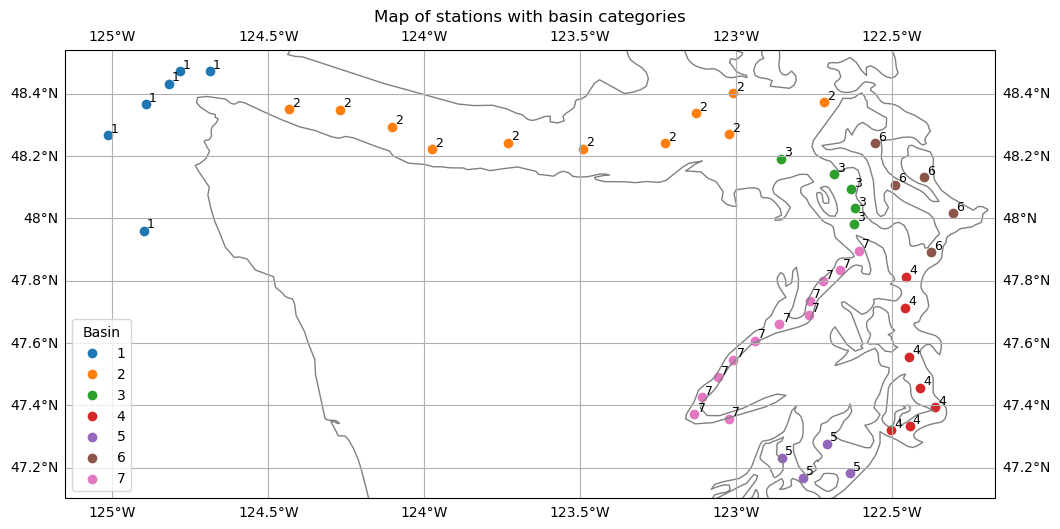

In [7]:
# plot the map of each station showing basin category as label

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# assign lon, lat, labels from the pivot_table
longitudes = pivot_table['LONGITUDE_DEC']
latitudes = pivot_table['LATITUDE_DEC']
labels = pivot_table['basin']

# Assign colors to each category
categories = pivot_table['basin'].unique()
color_map = {category: color for category, color in zip(categories, plt.cm.tab10.colors[:len(categories)])}

# Create a map with coastlines
fig, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Map of stations with basin categories')
ax.coastlines(color='gray')

# plot stations color-coded by basin
for category, color in color_map.items():
    subset = pivot_table[pivot_table['basin'] == category]
    plt.scatter(subset['LONGITUDE_DEC'], subset['LATITUDE_DEC'], label=category, color=color, transform=ccrs.PlateCarree())

# add labels
for lon, lat, label in zip(longitudes, latitudes, labels):
    ax.text(lon + 0.01, lat + 0.01, str(label), fontsize=9, transform=ccrs.PlateCarree())

# Add gridlines and legend
ax.gridlines(draw_labels=True)
ax.legend(title="Basin")

plt.savefig('station_map_with_basins_seacarb_2008_to_2024.png', 
    dpi=300, bbox_inches='tight')  # Save the frame as an image

# Show the map
plt.show()

### Select the features

The following features will be used for the independent variables to predict pH

In [8]:
candidate_features = [
    'RECOMMENDED_OXYGEN_MG_L',
    'MONTH_UTC',
    'CTDPRS_DBAR',
    'CTDTMP_DEG_C_ITS90',
    'CTDSAL_PSS78',
    'basin'
]

### Define X and y for the regression

In [10]:
X = df[candidate_features]
y = df['pH_total_Lueker']

### Split X and y into train and test subsets

In [11]:
# Split X and y into cross-validation train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Method 1. XGBoost regression

### a. Train the model with the training subset to find the optimum hyperparameters and selected features

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...

XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.937325    |
| MSE                |    0.0024962   |
| RMSE               |    0.049962    |
| Explained Variance |    0.937326    |
| MAE                |    0.0297268   |
| Max Error          |    0.646777    |
| MAPE               |    0.00382164  |
| MSLE               |    3.22435e-05 |
| n_samples          | 5221           |

Done
Time elapsed: 777.97 sec



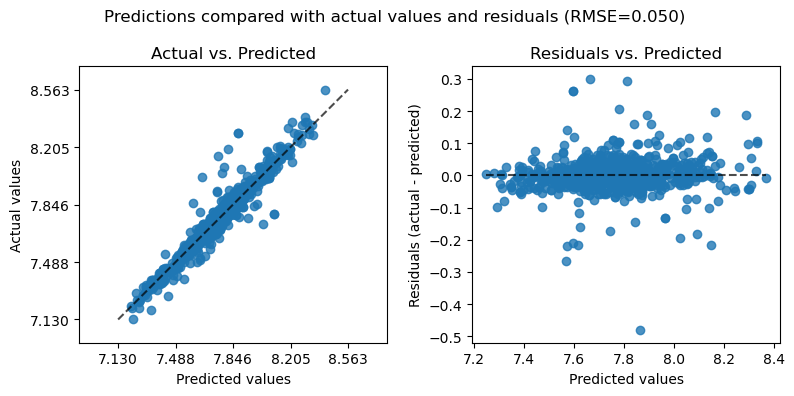

In [12]:
# Train the model with the training data subset
from PyMLR import xgb_auto
train_model_xgb, train_output_xgb = xgb_auto(X_train, y_train)

### b. Test the model with the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.902473    |
| MSE                |    0.00427037  |
| RMSE               |    0.0653481   |
| Explained Variance |    0.902661    |
| MAE                |    0.0389067   |
| Max Error          |    0.626323    |
| MAPE               |    0.00498077  |
| MSLE               |    5.49086e-05 |
| n_samples          | 1306           |



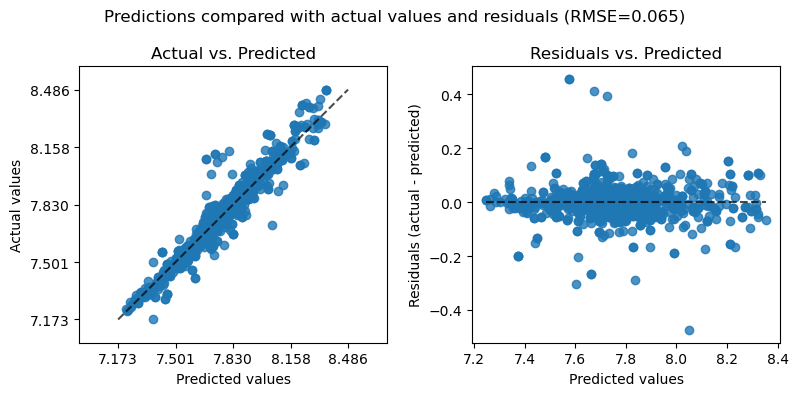

In [75]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output_xgb = test_model(train_model_xgb, X_test, y_test, 
    preprocess_result= train_output_xgb['preprocess_result'],
    selected_features= train_output_xgb['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_xgb['fig'].savefig("XGBRegressor_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c(i). Final fit using all of the data with hyperparameters and selected features from the training optimization

Fitting XGBRegressor model, please wait ...


XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.937252    |
| MSE                |    0.00254907  |
| RMSE               |    0.0504883   |
| Explained Variance |    0.937252    |
| MAE                |    0.0298283   |
| Max Error          |    0.653338    |
| MAPE               |    0.00383255  |
| MSLE               |    3.29206e-05 |
| n_samples          | 6527           |

Done
Time elapsed: 2.44 sec



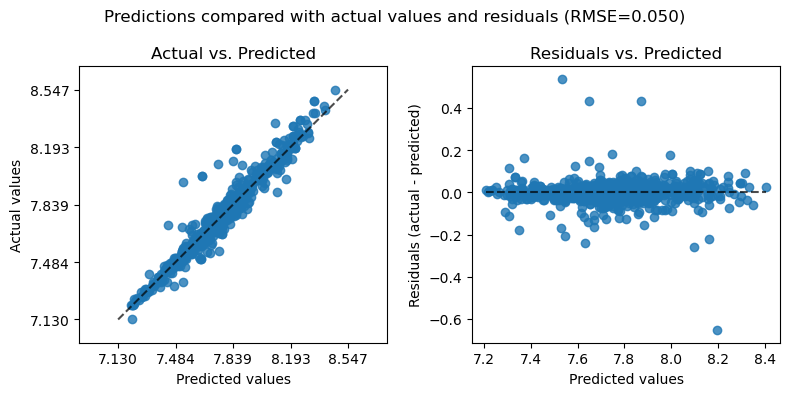

In [14]:
# Final fit of the model using all of the X and y data
from PyMLR import xgb
final_model_xgb, final_output_xgb = xgb(X, y, 
    **train_output_xgb['best_params'],
    selected_features= train_output_xgb['selected_features'])

### c(ii). Selected features from the fitted model

The optimization of XGBoost regression found the following set of selected features to be the optimum set for minimization of the MSE

In [15]:
train_output_xgb['selected_features']

['MONTH_UTC_2',
 'MONTH_UTC_3',
 'MONTH_UTC_4',
 'MONTH_UTC_5',
 'MONTH_UTC_6',
 'MONTH_UTC_7',
 'MONTH_UTC_8',
 'MONTH_UTC_9',
 'MONTH_UTC_10',
 'MONTH_UTC_11',
 'basin_1',
 'basin_2',
 'basin_3',
 'basin_4',
 'basin_5',
 'basin_6',
 'basin_7',
 'RECOMMENDED_OXYGEN_MG_L',
 'CTDPRS_DBAR',
 'CTDTMP_DEG_C_ITS90',
 'CTDSAL_PSS78']

# Method 2. CatBoost regression

### a. Train the model using the training subset to find the optimum hyperparameters and selected features

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting CatBoostRegressor model with best parameters, please wait ...

CatBoostRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   CatBoostRegressor |
|:-------------------|--------------------:|
| R-squared          |         0.939825    |
| MSE                |         0.00239663  |
| RMSE               |         0.0489554   |
| Explained Variance |         0.939825    |
| MAE                |         0.0293207   |
| Max Error          |         0.538071    |
| MAPE               |         0.00377187  |
| MSLE               |         3.10379e-05 |
| n_samples          |      5221           |

Done
Time elapsed: 3190.18 sec



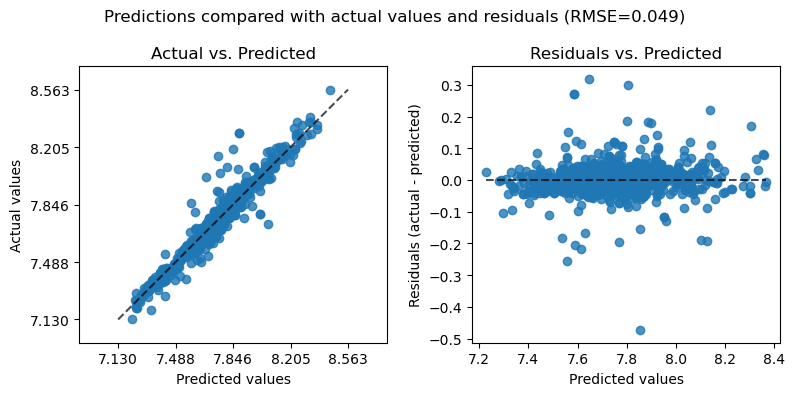

In [96]:
# Train the model with the training data subset
from PyMLR import catboost_auto
train_model_catboost, train_output_catboost = catboost_auto(X_train, y_train)

### b. Test the model using the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.907751    |
| MSE                |    0.00403929  |
| RMSE               |    0.0635554   |
| Explained Variance |    0.907928    |
| MAE                |    0.0374466   |
| Max Error          |    0.617926    |
| MAPE               |    0.00479571  |
| MSLE               |    5.20384e-05 |
| n_samples          | 1306           |



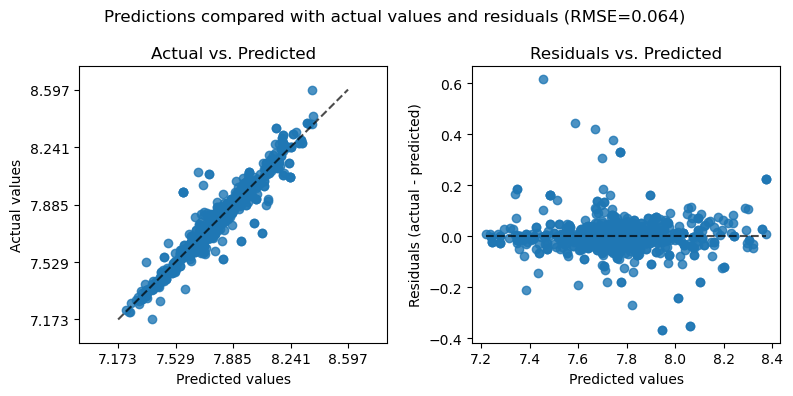

In [104]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output_catboost = test_model(train_model_catboost, X_test, y_test, 
    preprocess_result= train_output_catboost['preprocess_result'],
    selected_features= train_output_catboost['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_catboost['fig'].savefig("catboost_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c. Final fit using all of the data with selected features from the training optimization

Fitting CatBoostRegressor model, please wait ...


CatBoostRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   CatBoostRegressor |
|:-------------------|--------------------:|
| R-squared          |         0.927595    |
| MSE                |         0.00294138  |
| RMSE               |         0.0542345   |
| Explained Variance |         0.927595    |
| MAE                |         0.032022    |
| Max Error          |         0.610417    |
| MAPE               |         0.00411862  |
| MSLE               |         3.81382e-05 |
| n_samples          |      6527           |

Done
Time elapsed: 3.15 sec



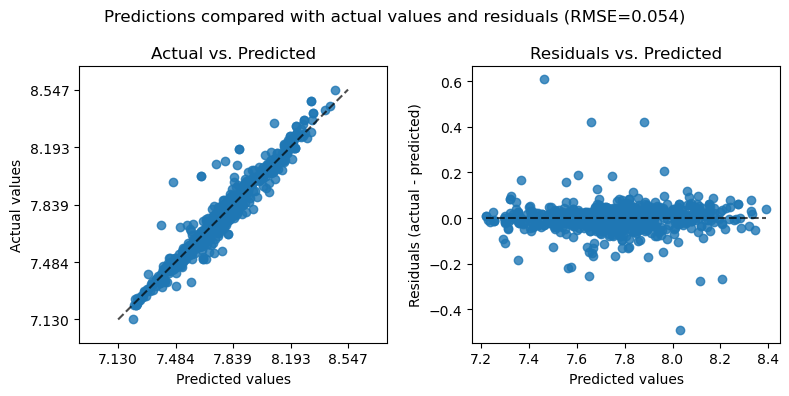

In [98]:
# Final fit of the model using all of the X and y data
from PyMLR import catboost
final_model_catboost, final_output_catboost = catboost(X, y, 
    **train_output_catboost['best_params'],
    selected_features= train_output_catboost['selected_features'])

# Method 3. Support Vector Regression (SVR)

### a. Train the model using the training subset to find the optimum hyperparameters and selected features

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting SVR model with best parameters, please wait ...

SVR goodness of fit to training data in model_outputs['stats']:

| Statistic          |           SVR |
|:-------------------|--------------:|
| R-squared          |    0.928911   |
| MSE                |    0.00283129 |
| RMSE               |    0.0532099  |
| Explained Variance |    0.928915   |
| MAE                |    0.0281567  |
| Max Error          |    0.587368   |
| MAPE               |    0.00362389 |
| MSLE               |    3.6725e-05 |
| n_samples          | 5221          |

Done
Time elapsed: 2169.39 sec



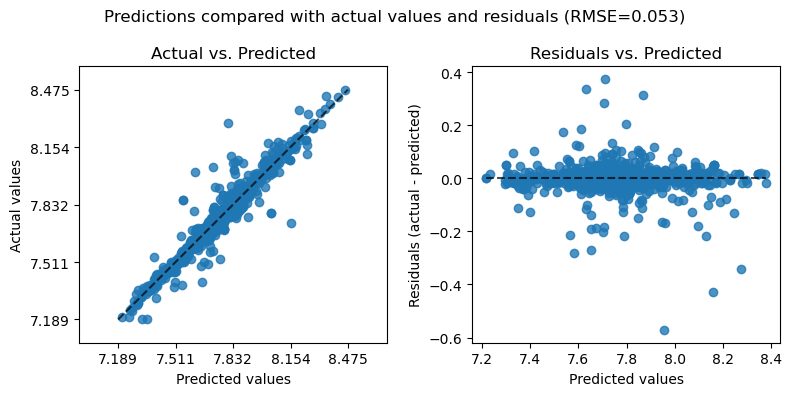

In [106]:
# Train the model with the training data subset
from PyMLR import svr_auto
train_model_svr, train_output_svr = svr_auto(X_train, y_train)

### b. Test the model using the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.909637    |
| MSE                |    0.00395671  |
| RMSE               |    0.0629024   |
| Explained Variance |    0.909743    |
| MAE                |    0.0342495   |
| Max Error          |    0.615492    |
| MAPE               |    0.00438928  |
| MSLE               |    5.09378e-05 |
| n_samples          | 1306           |



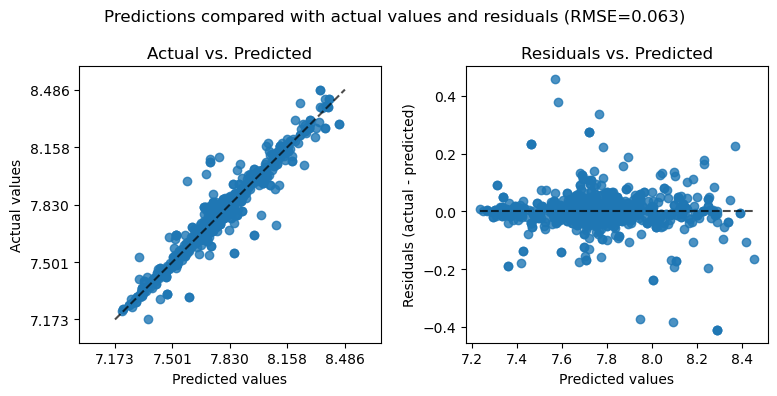

In [107]:
from PyMLR import test_model
test_output_svr = test_model(train_model_svr, X_test, y_test, 
    preprocess_result= train_output_svr['preprocess_result'],
    selected_features= train_output_svr['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_svr['fig'].savefig("svr_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c(i). Final fit using all of the data with selected features from the training optimization

Fitting SVR model, please wait ...


SVR goodness of fit to training data in model_outputs['stats']:

| Statistic          |            SVR |
|:-------------------|---------------:|
| R-squared          |    0.927657    |
| MSE                |    0.00293884  |
| RMSE               |    0.054211    |
| Explained Variance |    0.92766     |
| MAE                |    0.0285923   |
| Max Error          |    0.614996    |
| MAPE               |    0.0036781   |
| MSLE               |    3.81199e-05 |
| n_samples          | 6527           |

Done
Time elapsed: 2.93 sec



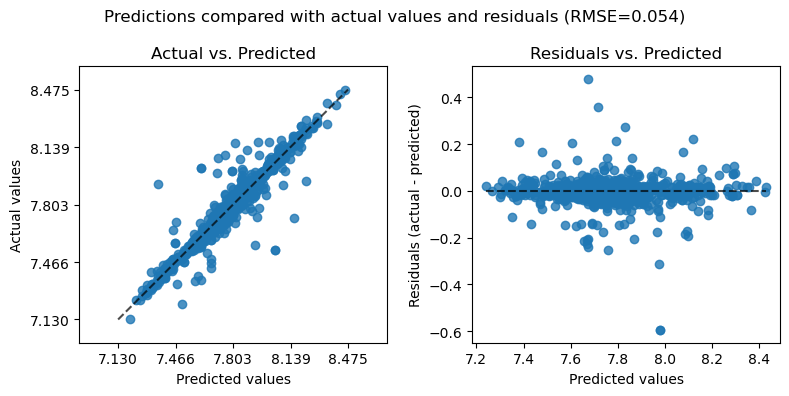

In [110]:
# Final fit of the model using all of the X and y data
from PyMLR import svr
final_model_svr, final_output_svr = svr(X, y, 
    **train_output_svr['best_params'],
    selected_features= train_output_svr['selected_features'])

### c(ii). Selected features from the fitted model

In [125]:
train_output_svr['selected_features']

['MONTH_UTC_2',
 'MONTH_UTC_3',
 'MONTH_UTC_4',
 'MONTH_UTC_5',
 'MONTH_UTC_6',
 'MONTH_UTC_7',
 'MONTH_UTC_9',
 'MONTH_UTC_10',
 'MONTH_UTC_11',
 'basin_1',
 'basin_2',
 'basin_3',
 'basin_4',
 'basin_5',
 'basin_6',
 'basin_7',
 'RECOMMENDED_OXYGEN_MG_L',
 'CTDPRS_DBAR',
 'CTDTMP_DEG_C_ITS90',
 'CTDSAL_PSS78']

# Method 4. K-Nearest Neighbors regression

### a. Train the model using the training subset to find the optimum hyperparameters and selected features

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting KNeighborsRegressor model with best parameters, please wait ...

KNeighborsRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   KNeighborsRegressor |
|:-------------------|----------------------:|
| R-squared          |           0.927551    |
| MSE                |           0.00288546  |
| RMSE               |           0.0537165   |
| Explained Variance |           0.927553    |
| MAE                |           0.0331269   |
| Max Error          |           0.684424    |
| MAPE               |           0.00425443  |
| MSLE               |           3.70998e-05 |
| n_samples          |        5221           |

Done
Time elapsed: 79.94 sec



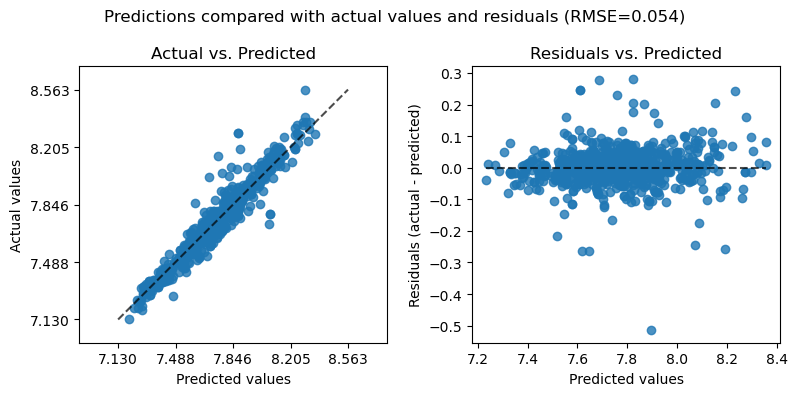

In [91]:
# Train the model with the training data subset
from PyMLR import knn_auto
train_model_knn, train_output_knn = knn_auto(X_train, y_train)

### b. Test the model using the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.885889    |
| MSE                |    0.00499654  |
| RMSE               |    0.0706862   |
| Explained Variance |    0.886117    |
| MAE                |    0.0432917   |
| Max Error          |    0.600734    |
| MAPE               |    0.00554864  |
| MSLE               |    6.40965e-05 |
| n_samples          | 1306           |



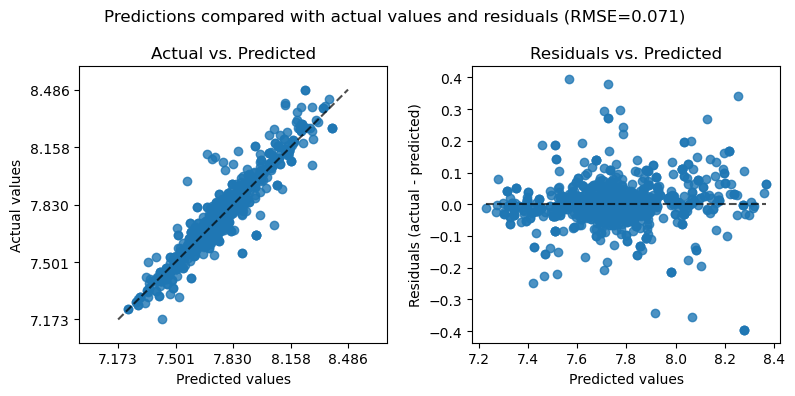

In [92]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output_knn = test_model(train_model_knn, X_test, y_test, 
    preprocess_result= train_output_knn['preprocess_result'],
    selected_features= train_output_knn['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_knn['fig'].savefig("KNN_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c. Final fit using all of the data with selected features from the training optimization

Fitting KNeighborsRegressor model, please wait ...


KNeighborsRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   KNeighborsRegressor |
|:-------------------|----------------------:|
| R-squared          |           0.929348    |
| MSE                |           0.00287016  |
| RMSE               |           0.0535738   |
| Explained Variance |           0.92935     |
| MAE                |           0.0327126   |
| Max Error          |           0.65417     |
| MAPE               |           0.00420041  |
| MSLE               |           3.69197e-05 |
| n_samples          |        6527           |

Done
Time elapsed: 0.40 sec



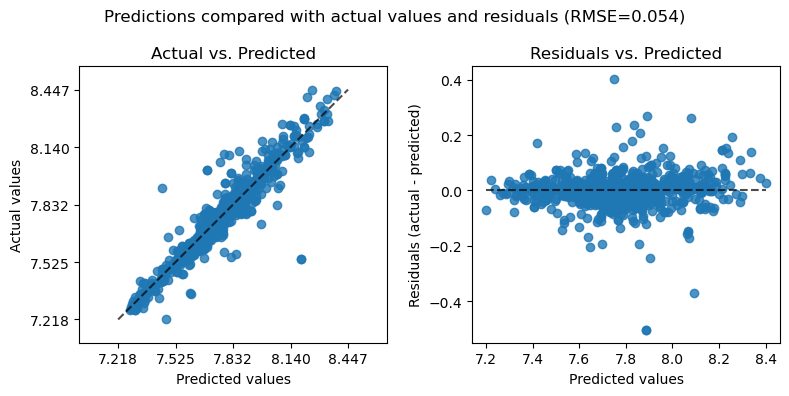

In [99]:
# Final fit of the model using all of the X and y data
from PyMLR import knn
final_model_knn, final_output_knn = knn(X, y, 
    **train_output_knn['best_params'],
    selected_features= train_output_knn['selected_features'])

# Method 5. Lasso regression

### a. Train the model using the training subset to find the optimum hyperparameters and selected features

Fitting Lasso regression models, please wait ...

Lasso regression statistics of best models in model_outputs['stats']:

| Statistic          |          LassoCV |      LassoLarsCV |     LassoLarsAIC |     LassoLarsBIC |
|:-------------------|-----------------:|-----------------:|-----------------:|-----------------:|
| alpha              |      0.0001766   |      2.31784e-05 |      3.25472e-05 |      3.25472e-05 |
| r-squared          |      0.873945    |      0.874334    |      0.874327    |      0.874327    |
| adjusted r-squared |      0.873485    |      0.873851    |      0.873868    |      0.873868    |
| n_samples          |   5221           |   5221           |   5221           |   5221           |
| df residuals       |   5202           |   5201           |   5202           |   5202           |
| df model           |     18           |     19           |     18           |     18           |
| F-statistic        |   2003.66        |   1904.55        |   2010.61        |   2010.

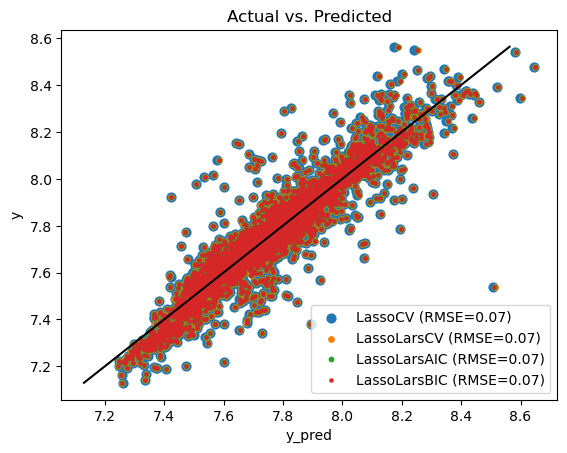

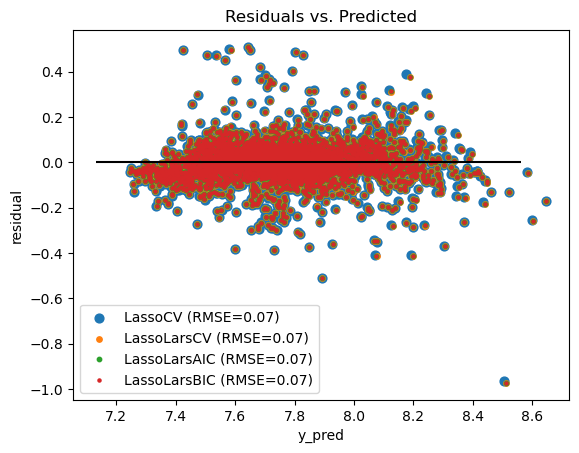

In [16]:
# Train the model with the training data subset
from PyMLR import lasso
train_model_lasso, train_output_lasso = lasso(X_train, y_train, verbose=1)

In [17]:
# Show intercept and coefficients of fitted LassoLarsBIC model (train)
from PyMLR import show_coef
fitted_model = train_model_lasso['LassoLarsBIC']
X_proc = train_output_lasso['X_processed']
popt_lasso_train = show_coef(fitted_model, X_proc)

| Feature                 |   Parameter |
|:------------------------|------------:|
| Intercept               |  7.73871    |
| MONTH_UTC_2             | -0.0708261  |
| MONTH_UTC_3             | -0.0453294  |
| MONTH_UTC_4             | -0.0298815  |
| MONTH_UTC_5             |  0.00317443 |
| MONTH_UTC_6             |  0          |
| MONTH_UTC_7             |  0.0096056  |
| MONTH_UTC_8             |  0.0444975  |
| MONTH_UTC_9             |  0.00201243 |
| MONTH_UTC_10            |  0          |
| MONTH_UTC_11            | -0.0350412  |
| basin_1                 |  0.147487   |
| basin_2                 |  0.100952   |
| basin_3                 |  0.0563852  |
| basin_4                 | -0.00408146 |
| basin_5                 | -0.0127135  |
| basin_6                 |  0          |
| basin_7                 | -0.00116245 |
| RECOMMENDED_OXYGEN_MG_L |  0.187619   |
| CTDPRS_DBAR             |  0.0173654  |
| CTDTMP_DEG_C_ITS90      |  0.0337895  |
| CTDSAL_PSS78            |  0.002

### b. Test the model using the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.876414    |
| MSE                |    0.00541144  |
| RMSE               |    0.0735625   |
| Explained Variance |    0.876457    |
| MAE                |    0.047892    |
| Max Error          |    0.573467    |
| MAPE               |    0.00615111  |
| MSLE               |    6.97863e-05 |
| n_samples          | 1306           |



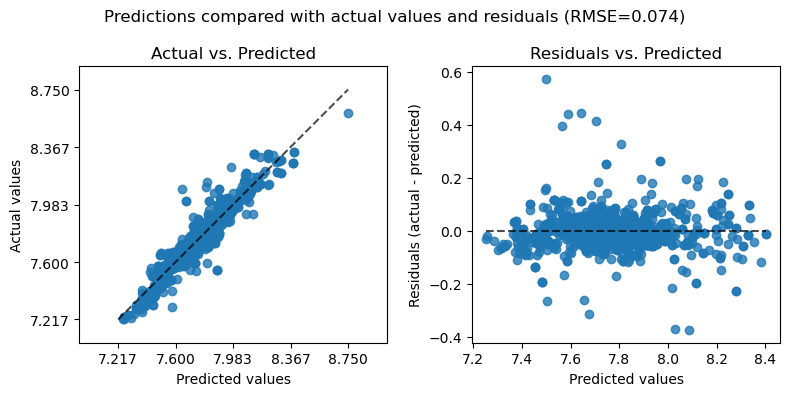

In [76]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output_lasso = test_model(train_model_lasso['LassoLarsBIC'], X_test, y_test, 
    preprocess_result= train_output_lasso['preprocess_result'],
    selected_features= train_output_lasso['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_lasso['fig'].savefig("LassoLarsBIC_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c(i). Final fit using all of the data with selected features from the training optimization

Fitting Lasso regression models, please wait ...

Lasso regression statistics of best models in model_outputs['stats']:

| Statistic          |          LassoCV |      LassoLarsCV |     LassoLarsAIC |     LassoLarsBIC |
|:-------------------|-----------------:|-----------------:|-----------------:|-----------------:|
| alpha              |      0.000178973 |      7.00431e-05 |      7.90679e-06 |      7.90679e-06 |
| r-squared          |      0.874471    |      0.874817    |      0.874879    |      0.874879    |
| adjusted r-squared |      0.874124    |      0.874452    |      0.874514    |      0.874514    |
| n_samples          |   6527           |   6527           |   6527           |   6527           |
| df residuals       |   6509           |   6508           |   6508           |   6508           |
| df model           |     17           |     18           |     18           |     18           |
| F-statistic        |   2667.27        |   2526.67        |   2528.1         |   2528.

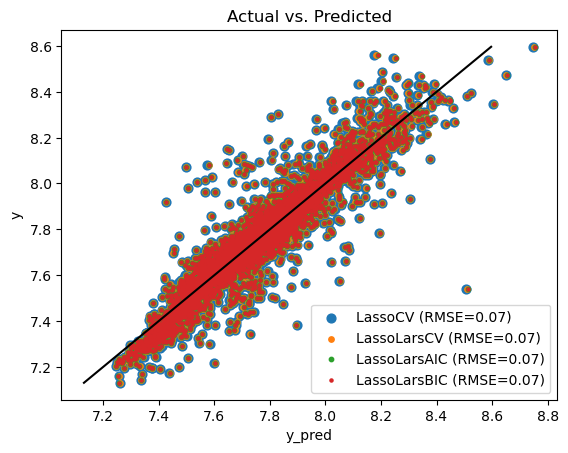

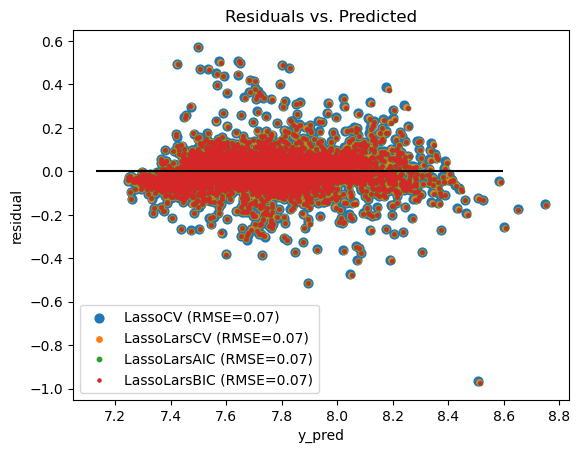

In [19]:
# Final fit of the model using all of the X and y data
from PyMLR import lasso
final_model_lasso, final_output_lasso = lasso(X, y, verbose=1,
    selected_features= train_output_lasso['selected_features'])

### c(ii). Show the intercept and coefficients of the final fitted Lasso model

In [20]:
# Show intercept and coefficients of fitted LassoLarsBIC model (final)
from PyMLR import show_coef
fitted_model = final_model_lasso['LassoLarsBIC']
X_proc = final_output_lasso['X_processed']
popt_lasso_final = show_coef(fitted_model, X_proc)

| Feature                 |    Parameter |
|:------------------------|-------------:|
| Intercept               |  7.73968     |
| MONTH_UTC_2             | -0.0715328   |
| MONTH_UTC_3             | -0.051128    |
| MONTH_UTC_4             | -0.0285692   |
| MONTH_UTC_5             |  0.000569568 |
| MONTH_UTC_6             |  0           |
| MONTH_UTC_7             |  0.00944248  |
| MONTH_UTC_8             |  0.0420565   |
| MONTH_UTC_9             |  0.00297533  |
| MONTH_UTC_10            |  0           |
| MONTH_UTC_11            | -0.0368896   |
| basin_1                 |  0.14311     |
| basin_2                 |  0.100314    |
| basin_3                 |  0.0576002   |
| basin_4                 | -0.00442585  |
| basin_5                 | -0.0144463   |
| basin_6                 |  0           |
| basin_7                 | -0.001242    |
| RECOMMENDED_OXYGEN_MG_L |  0.190193    |
| CTDPRS_DBAR             |  0.017918    |
| CTDTMP_DEG_C_ITS90      |  0.0330756   |
| CTDSAL_PS

# Method 6. Stepwise regression to minimize BIC

### a(i). Fit the model with the training data using PyMLR stepwise to find optimum selected features

Fitting Stepwise models, please wait ...

Model skill and features at each step in model_outputs['step_features']:

|   Step |       AIC |       BIC |   rsq_adj | Features                                                                    |
|-------:|----------:|----------:|----------:|:----------------------------------------------------------------------------|
|      0 |  -2009.74 |  -2003.18 |  0        | []                                                                          |
|      1 |  -9986.17 |  -9973.05 |  0.78302  | ['RECOMMENDED_OXYGEN_MG_L']                                                 |
|      2 | -10611    | -10591.3  |  0.807529 | ['RECOMMENDED_OXYGEN_MG_L' 'MONTH_UTC_4']                                   |
|      3 | -11196.2  | -11170    |  0.827972 | ['RECOMMENDED_OXYGEN_MG_L' 'MONTH_UTC_4' 'basin_1']                         |
|      4 | -11660.8  | -11628    |  0.842647 | ['RECOMMENDED_OXYGEN_MG_L' 'MONTH_UTC_4' 'basin_1' 'MONTH_UTC_2']           |
|      5 

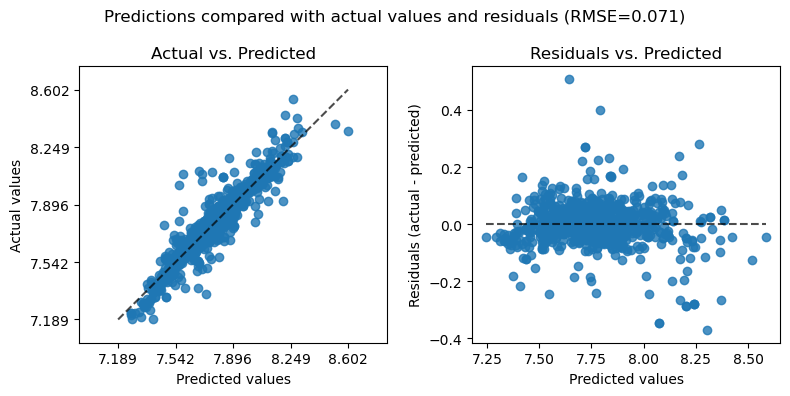

In [21]:
# Train the model with the training data subset
from PyMLR import stepwise
train_model_stepBIC, train_output_stepBIC = stepwise(
    X_train, y_train, criterion='bic', use_scaler=False,
    allow_dummies=True, direction='forward')

### a(ii). Fit the model to the training data using PyMLR linear with the selected features from PyMLR stepwise BIC

This step converts the training model from a(i) into an sklearn model object to allow use to more easily look at model agnostics

In [22]:
train_output_stepBIC['selected_features']

['RECOMMENDED_OXYGEN_MG_L',
 'MONTH_UTC_4',
 'basin_1',
 'MONTH_UTC_2',
 'basin_2',
 'CTDTMP_DEG_C_ITS90',
 'basin_3',
 'CTDPRS_DBAR',
 'MONTH_UTC_8',
 'MONTH_UTC_3',
 'MONTH_UTC_11',
 'MONTH_UTC_7',
 'basin_5']

Fitting LinearRegression model, please wait ...

LinearRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LinearRegression |
|:-------------------|-------------------:|
| r-squared          |        0.874276    |
| adjusted r-squared |        0.873962    |
| n_samples          |     5221           |
| df residuals       |     5208           |
| df model           |       12           |
| F-statistic        |     3017.99        |
| Prob (F-statistic) |        1.11022e-16 |
| RMSE               |        0.0707624   |
| Log-Likelihood     |     6419.17        |
| AIC                |   -12812.3         |
| BIC                |   -12727           |

Parameters of fitted model in model_outputs['popt']:

| Feature                 |    Parameter |
|:------------------------|-------------:|
| Intercept               |  7.03519     |
| RECOMMENDED_OXYGEN_MG_L |  0.0782054   |
| MONTH_UTC_4             | -0.0328071   |
| basin_1                 |  0.

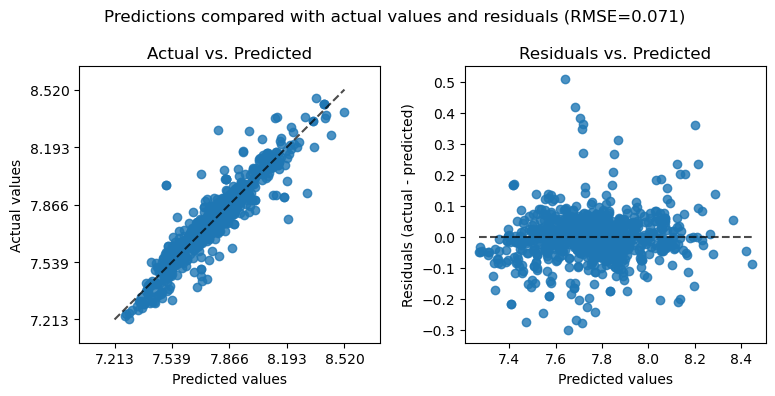

In [23]:
from PyMLR import linear
train_model_linear, train_output_linear = linear(
    X_train, y_train, 
    use_scaler=False,
    selected_features = train_output_stepBIC['selected_features']
    )

### b. Test the trained model with the testing data and the selected features from stepwise BIC training


Goodness of fit to testing data in result['metrics']:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.876236    |
| MSE                |    0.00541921  |
| RMSE               |    0.0736153   |
| Explained Variance |    0.876281    |
| MAE                |    0.0479839   |
| Max Error          |    0.57371     |
| MAPE               |    0.00616322  |
| MSLE               |    6.99052e-05 |
| n_samples          | 1306           |



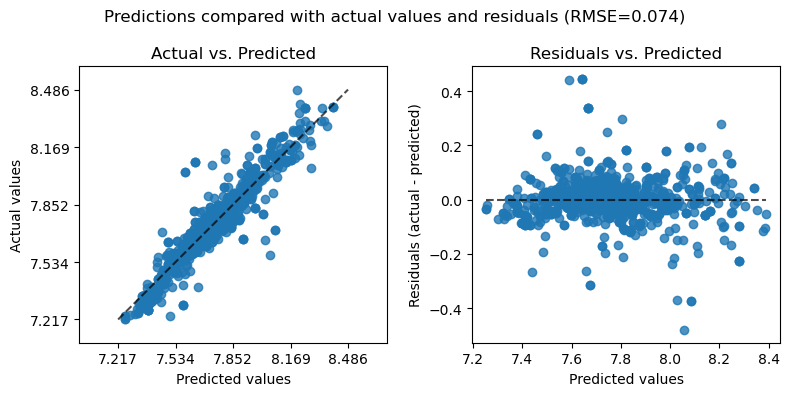

In [78]:
from PyMLR import test_model
test_output_linear = test_model(train_model_linear, X_test, y_test, 
    preprocess_result= train_output_linear['preprocess_result'],
    selected_features= train_output_linear['selected_features'])

# save the plot of predictions vs actual and residuals
test_output_linear['fig'].savefig("LinearRegression_predictions_test_Salish_Sea_pH_vs_DO_mgl_v05.png", dpi=300)

### c. Final fit of a linear regression model to all of the data with selected features from stepwise BIC training

Fitting LinearRegression model, please wait ...

LinearRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LinearRegression |
|:-------------------|-------------------:|
| r-squared          |        0.874797    |
| adjusted r-squared |        0.874547    |
| n_samples          |     6527           |
| df residuals       |     6514           |
| df model           |       12           |
| F-statistic        |     3792.79        |
| Prob (F-statistic) |        1.11022e-16 |
| RMSE               |        0.0713176   |
| Log-Likelihood     |     7973.86        |
| AIC                |   -15921.7         |
| BIC                |   -15833.5         |

Parameters of fitted model in model_outputs['popt']:

| Feature                 |    Parameter |
|:------------------------|-------------:|
| Intercept               |  7.03597     |
| RECOMMENDED_OXYGEN_MG_L |  0.0782287   |
| MONTH_UTC_4             | -0.030926    |
| basin_1                 |  0.

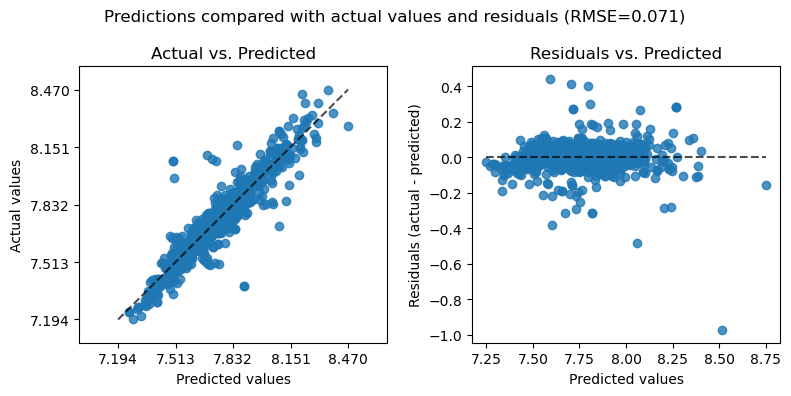

In [25]:
from PyMLR import linear
final_model_linear, final_output_linear = linear(
    X, y, 
    use_scaler=False,
    selected_features = train_output_stepBIC['selected_features']
    )

### d. Model agnostics using predictions from test data from the mode that was fit to the training data

Performing 4-step model agnostic analysis, please wait...

Step 1: Model skill metrics and residuals plot, please wait...

Model skill metrics:

| Statistic          |      Regressor |
|:-------------------|---------------:|
| R-squared          |    0.876236    |
| MSE                |    0.00541921  |
| RMSE               |    0.0736153   |
| Explained Variance |    0.876281    |
| MAE                |    0.0479839   |
| Max Error          |    0.57371     |
| MAPE               |    0.00616322  |
| MSLE               |    6.99052e-05 |
| n_samples          | 1306           |



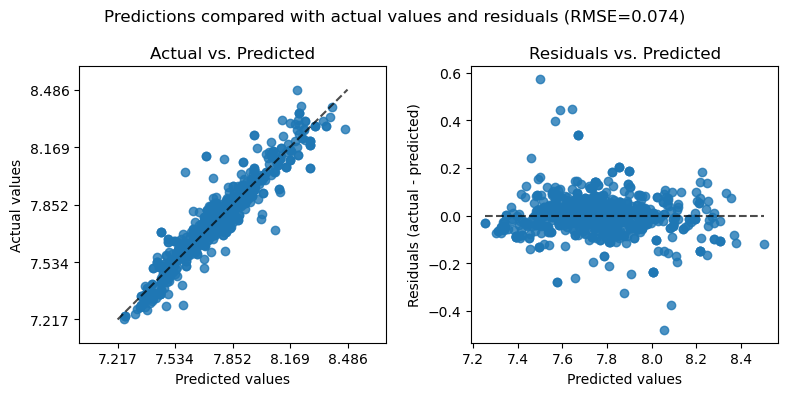

Step 2: SHAP Beeswarm and Bar importance...


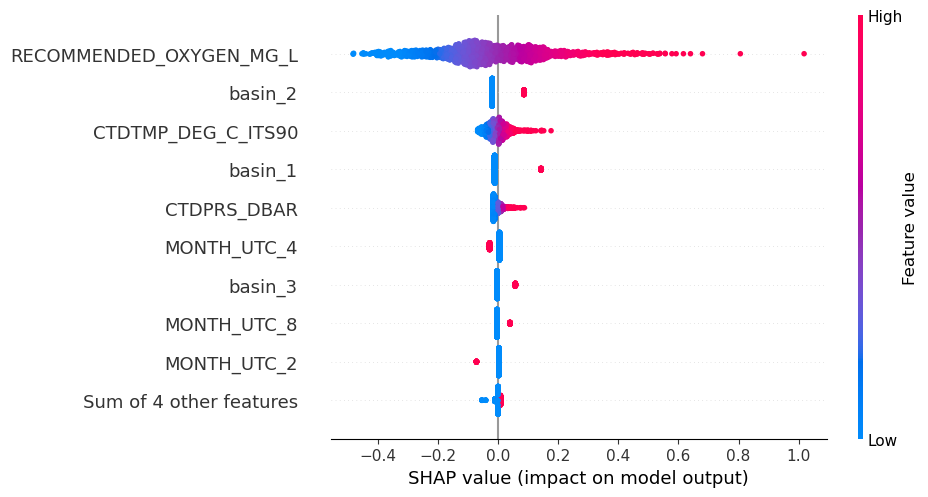

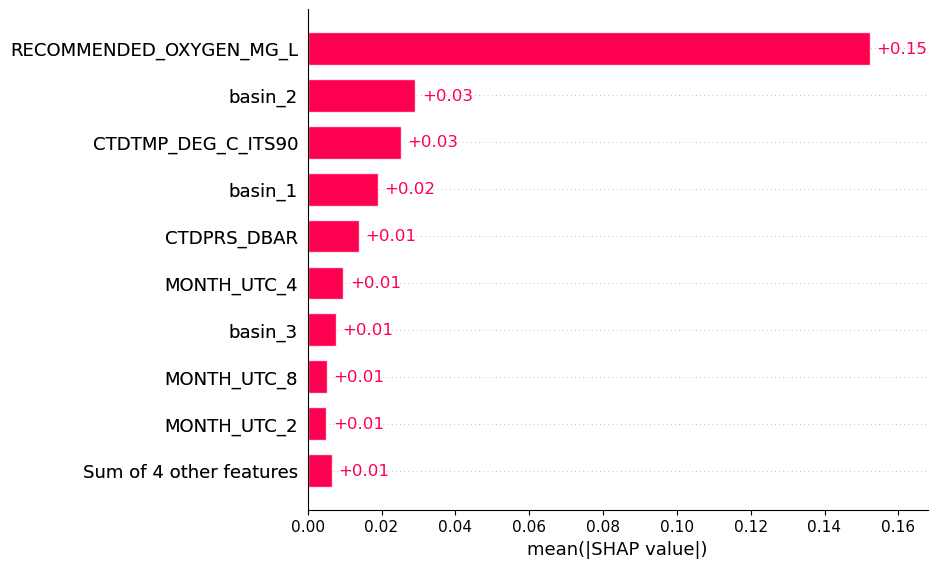

Step 3: Permutation Importance...


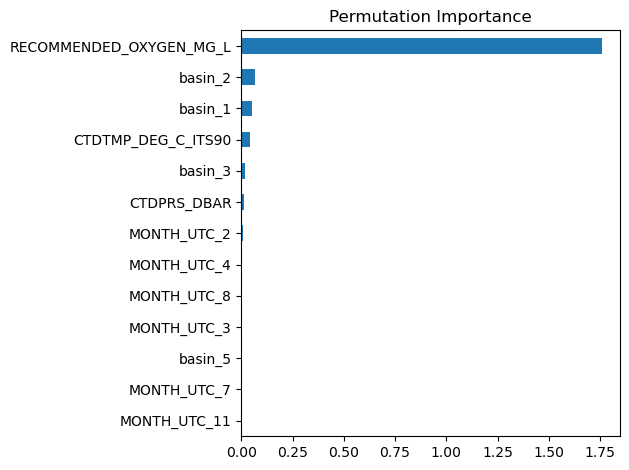

Step 4: PDP + ICE plots of each continuous features...
processing feature:  RECOMMENDED_OXYGEN_MG_L


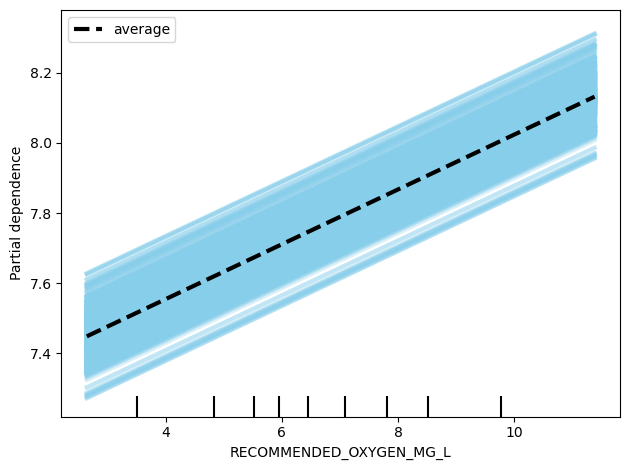

processing feature:  CTDTMP_DEG_C_ITS90


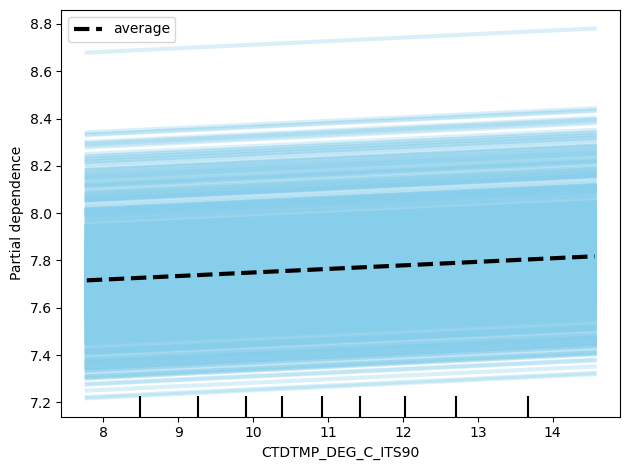

processing feature:  CTDPRS_DBAR


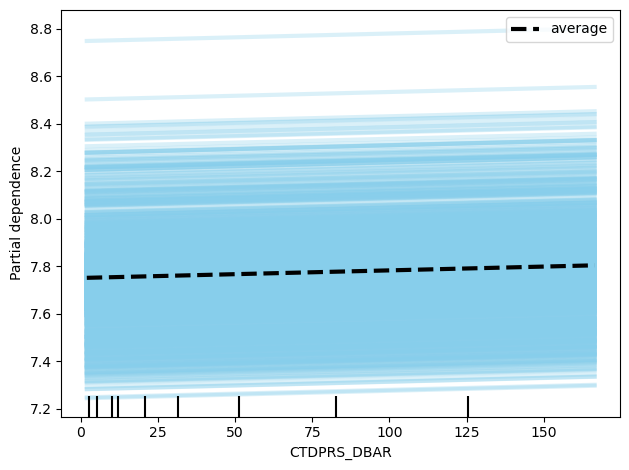

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 6.16 sec



In [26]:
# Model agnostics
from PyMLR import model_agnostic
agnostic_output_linear = model_agnostic(train_model_linear, X_test, y_test, 
    preprocess_result= train_output_linear['preprocess_result'],
    selected_features= train_output_linear['selected_features'],
    output_dir= 'model_agnostic',
    show=True)

# Comparison of the test results for the various methods

### Table of R-squared and RMSE for each method for the train, test, and final steps

Table 1 below shows model skill metrics (R-squared and RMSE) for each regression method for the train, test, and final steps. The goodness-of-fit for the test data (shown in step b in Table 1) provide the best estimate of how well the model is expected to perform on new data that were not used to train the model.

The Support Vector Regression (SVR) method has the best model skill as shown in Table 1 (test model R-squared 0.9096 and RMSE=0.0629 pH units). The stepwise regression results have the lowest model skill (test model R-squared 0.8762 and RMSE=0.0736 pH units), but are still fairly good, explainining about 88% of the variability in pH, and are more easily interpreted and applied.

In [218]:
# Table of R-squared and RMSE for each method train, test, final
summary_stats = pd.DataFrame()
summary_stats['Method'] = [
    'XGBoost','','',
    'CatBoost','','',
    'SVR','','',
    'KNN','','',
    'Lasso','','',
    'Stepwise','',''      
]
summary_stats['Step'] = [
    'a. train','b. test','c. final',
    'a. train','b. test','c. final',
    'a. train','b. test','c. final',
    'a. train','b. test','c. final',
    'a. train','b. test','c. final',
    'a. train','b. test','c. final'
]
summary_stats['R-squared'] = [
    train_output_xgb['metrics']['R-squared'],test_output_xgb['metrics']['R-squared'],final_output_xgb['metrics']['R-squared'],
    train_output_catboost['metrics']['R-squared'],test_output_catboost['metrics']['R-squared'],final_output_catboost['metrics']['R-squared'],
    train_output_svr['metrics']['R-squared'],test_output_svr['metrics']['R-squared'],final_output_svr['metrics']['R-squared'],
    train_output_knn['metrics']['R-squared'],test_output_knn['metrics']['R-squared'],final_output_knn['metrics']['R-squared'],
    train_output_lasso['stats']['LassoLarsBIC']['r-squared'],test_output_lasso['metrics']['R-squared'],final_output_lasso['stats']['LassoLarsBIC']['r-squared'],
    train_output_linear['stats']['LinearRegression']['r-squared'],test_output_linear['metrics']['R-squared'],final_output_linear['stats']['LinearRegression']['r-squared']
]
summary_stats['RMSE'] = [
    train_output_xgb['metrics']['RMSE'],test_output_xgb['metrics']['RMSE'],final_output_xgb['metrics']['RMSE'],
    train_output_catboost['metrics']['RMSE'],test_output_catboost['metrics']['RMSE'],final_output_catboost['metrics']['RMSE'],
    train_output_svr['metrics']['RMSE'],test_output_svr['metrics']['RMSE'],final_output_svr['metrics']['RMSE'],
    train_output_knn['metrics']['RMSE'],test_output_knn['metrics']['RMSE'],final_output_knn['metrics']['RMSE'],
    train_output_lasso['stats']['LassoLarsBIC']['RMSE'],test_output_lasso['metrics']['RMSE'],final_output_lasso['stats']['LassoLarsBIC']['RMSE'],
    train_output_linear['stats']['LinearRegression']['RMSE'],test_output_linear['metrics']['RMSE'],final_output_linear['stats']['LinearRegression']['RMSE']
]
summary_stats['N'] = [
    train_output_xgb['metrics']['n_samples'],test_output_xgb['metrics']['n_samples'],final_output_xgb['metrics']['n_samples'],
    train_output_catboost['metrics']['n_samples'],test_output_catboost['metrics']['n_samples'],final_output_catboost['metrics']['n_samples'],
    train_output_svr['metrics']['n_samples'],test_output_svr['metrics']['n_samples'],final_output_svr['metrics']['n_samples'],
    train_output_knn['metrics']['n_samples'],test_output_knn['metrics']['n_samples'],final_output_knn['metrics']['n_samples'],
    train_output_lasso['stats']['LassoLarsBIC']['n_samples'],test_output_lasso['metrics']['n_samples'],final_output_lasso['stats']['LassoLarsBIC']['n_samples'],
    train_output_linear['stats']['LinearRegression']['n_samples'],test_output_linear['metrics']['n_samples'],final_output_linear['stats']['LinearRegression']['n_samples']
]
summary_stats['N'] = summary_stats['N'].astype(int)
summary_stats.to_excel('SalishCruises_regression_summary_stats.xlsx', index=False)
print('Table 1. R-squared, RMSE, and N for train, test, and final steps\n')
print(summary_stats.to_markdown(index=False,floatfmt=".4f"))

Table 1. R-squared, RMSE, and N for train, test, and final steps

| Method   | Step     |   R-squared |   RMSE |    N |
|:---------|:---------|------------:|-------:|-----:|
| XGBoost  | a. train |      0.9373 | 0.0500 | 5221 |
|          | b. test  |      0.9025 | 0.0653 | 1306 |
|          | c. final |      0.9373 | 0.0505 | 6527 |
| CatBoost | a. train |      0.9398 | 0.0490 | 5221 |
|          | b. test  |      0.9078 | 0.0636 | 1306 |
|          | c. final |      0.9276 | 0.0542 | 6527 |
| SVR      | a. train |      0.9289 | 0.0532 | 5221 |
|          | b. test  |      0.9096 | 0.0629 | 1306 |
|          | c. final |      0.9277 | 0.0542 | 6527 |
| KNN      | a. train |      0.9276 | 0.0537 | 5221 |
|          | b. test  |      0.8859 | 0.0707 | 1306 |
|          | c. final |      0.9293 | 0.0536 | 6527 |
| Lasso    | a. train |      0.8743 | 0.0707 | 5221 |
|          | b. test  |      0.8764 | 0.0736 | 1306 |
|          | c. final |      0.8749 | 0.0713 | 6527 |
| Stepwise | a. 

### QQ-plot of predicted pH for test data compared with observed test data for each method 

A QQ plot, or quantile-quantile plot, compares the distribution of a dataset with a theoretical distribution, in our case the normal distribution. This helps assess whether the data follows the normal distribution by plotting the quantiles of the dataset against the quantiles of the normal distribution.

If the data aligns closely with a straight line fit to the observations in the QQ plot, that suggests that the dataset follows the theoretical distribution. In the QQ plot below we see that the pH observations align fairly closely with the fit line (R-squared=0.976).

The QQ plots for pH predictions from each regression method align closely with the observations. This shows that all of the methods have good skill for representing the distribution of observations.

In [126]:
# Predicted pH for the test data subset for each method
pH_test_xgb = test_output_xgb['y_pred']
pH_test_catboost = test_output_catboost['y_pred']
pH_test_svr = test_output_svr['y_pred']
pH_test_knn = test_output_knn['y_pred']
pH_test_lasso = test_output_lasso['y_pred']
pH_test_linear = test_output_linear['y_pred']

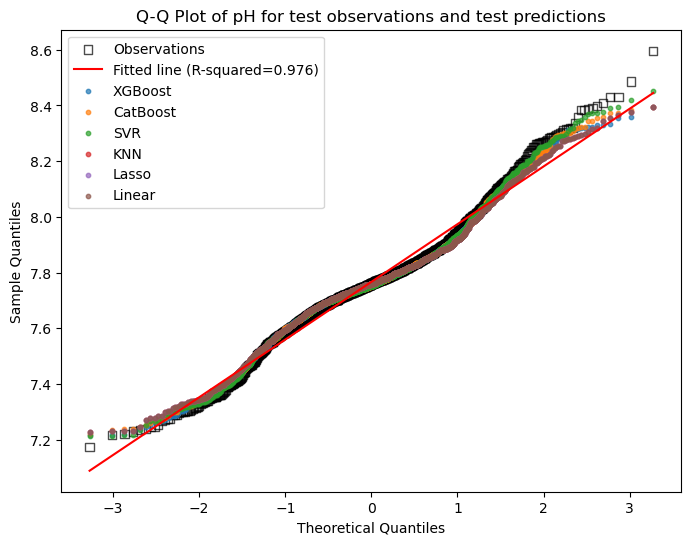

In [216]:
# QQ plot to compare the observed vs predicted pH of the teat data subset
import scipy.stats as stats

data1 = y_test        # final training data
data2 = pH_test_xgb  
data3 = pH_test_catboost
data4 = pH_test_svr
data5 = pH_test_knn
data6 = pH_test_lasso
data7 = pH_test_linear

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")
qq3 = stats.probplot(data3, dist="norm")
qq4 = stats.probplot(data4, dist="norm")
qq5 = stats.probplot(data5, dist="norm")
qq6 = stats.probplot(data5, dist="norm")
qq7 = stats.probplot(data5, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Create a probability plot
res = stats.probplot(data1, dist="norm", plot=None)

# Plot the data points and the fitted line manually
plt.scatter(res[0][0], res[0][1], marker='s', facecolors='none', edgecolors='black', label='Observations', alpha=0.7)
# print(res[1])
slope, intercept, rvalue = res[1]
rsquared = rvalue ** 2
x = np.linspace(min(res[0][0]), max(res[0][0]), 100)
plt.plot(x, slope * x + intercept, label=f"Fitted line (R-squared={rsquared:.3f})", color="red")

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color=color_map[1], label='XGBoost', alpha=0.7, s=10)
plt.scatter(qq3[0][0], qq3[0][1], color=color_map[2], label='CatBoost', alpha=0.7, s=10)
plt.scatter(qq4[0][0], qq4[0][1], color=color_map[3], label='SVR', alpha=0.7, s=10)
plt.scatter(qq5[0][0], qq5[0][1], color=color_map[4], label='KNN', alpha=0.7, s=10)
plt.scatter(qq6[0][0], qq6[0][1], color=color_map[5], label='Lasso', alpha=0.7, s=10)
plt.scatter(qq7[0][0], qq7[0][1], color=color_map[6], label='Linear', alpha=0.7, s=10)

# Customize the plot
plt.title(f'Q-Q Plot of pH for test observations and test predictions')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

plt.savefig("QQ_plot_pH_test.png", dpi=300)

# Show the plot
plt.show()

# Predicted pH for all oxygen observations

Next we will use the regression models to predict pH for all oxygen observations in the Salish Sea. This data set includes over 13000 observations of dissolved oxygen.

### Read the csv of the full data set for oxygen in the Salish Sea

In [302]:
# Read the csv of the full data set for oxygen in the Salish Sea
# fn = 'SalishCruises_2008to2018_MeasCalcParamsToNCEI_12162024.csv'
fn_full = 'SalishCruise_2008to2024_forQC_07232025_basins.csv'   # email from Simone Alin 7/29/2025
df_full = pd.read_csv(fn_full)
dtypes = show_dtypes(df_full)

                              dtype nunique isna_sum
Unnamed: 0                    int64   13223        0
RECORD                        int64   13223        0
EXPOCODE                     object      45        0
CRUISE_ID                    object      62        0
DATE_UTC                     object     264        0
TIME_UTC                     object    9506        0
DATE_LOCAL                   object     258        0
TIME_LOCAL                   object   10069        0
LONGITUDE_DEC               float64    2062        0
LATITUDE_DEC                float64    2055        0
STATION_NO                  float64      58        8
NISKIN_NO                     int64      24        0
NISKIN_NO_FLAG_W              int64       3        0
CTDPRS_DBAR                 float64    4060        0
CTDTMP_DEG_C_ITS90          float64    1112        0
CTDTMP_FLAG_W                 int64       2        0
CTDSAL_PSS78                float64     978       20
CTDSAL_FLAG_W                 int64       3   

### Make a pivot table of average station lon, lat, basin to find which stations have missing basins

In [303]:
# make a pivot table of average station lon, lat, basin to find which stations have missing basins
import pandas as pd

# Creating a pivot table
pivot_full = pd.pivot_table(
    df_full,
    values=['LONGITUDE_DEC', 'LATITUDE_DEC', 'basin'],  # Columns to aggregate
    index=['STATION_NO'],             # Rows
    columns=None,       # Columns
    aggfunc='mean',                  # Aggregation function
    fill_value=np.nan                    # Fill missing values with nan
)
# pivot_full['basin'] = pivot_full['basin'].astype(int)
# print(pivot_full)

# pivot_full = pivot_full.sort_values(by='basin')

### Map of stations to eyball which basins should be assigned to the stations missing basins

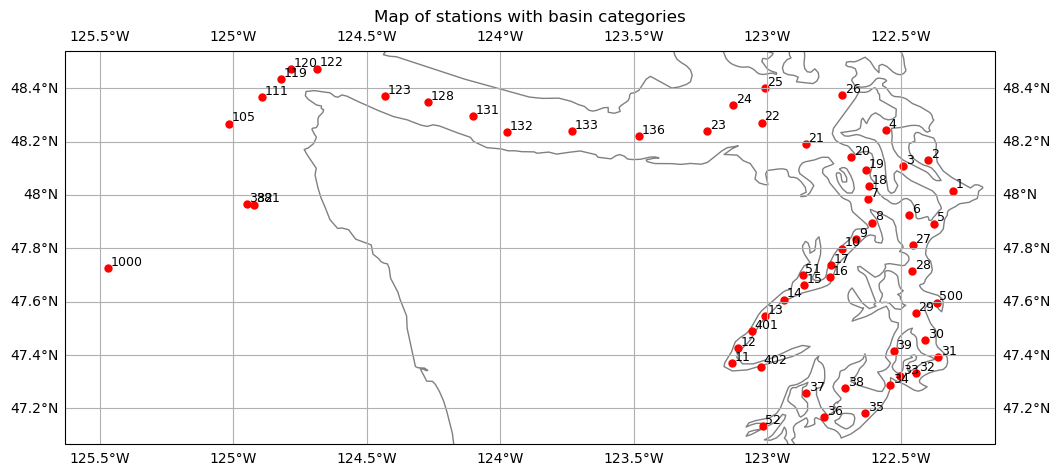

In [304]:
# map of stations to eyball which basins should be assigned to the stations missing basins
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

longitudes = pivot_full['LONGITUDE_DEC']
latitudes = pivot_full['LATITUDE_DEC']
stations = pivot_full.index.astype(int)

# Create a map with coastlines
fig, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Map of stations with basin categories')
ax.coastlines(color='gray')

# Add points from the CSV
ax.scatter(longitudes, latitudes, color='red', s=3, transform=ccrs.PlateCarree(), label='Locations')

# Plot points and basin labels
#  for lon, lat, label in zip(longitudes, latitudes, labels):
#     ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
#     ax.text(lon + 0.01, lat + 0.01, str(label), fontsize=9, transform=ccrs.PlateCarree())

# plots points and station labels
for lon, lat, label in zip(longitudes, latitudes, stations):
    ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax.text(lon + 0.01, lat + 0.01, str(label), fontsize=9, transform=ccrs.PlateCarree())

# Add gridlines and legend
ax.gridlines(draw_labels=True)
# ax.legend()

# plt.savefig('station_map_with_basins.png', 
#     dpi=300, bbox_inches='tight')  # Save the frame as an image

# Show the map
plt.show()
# ''';

### Fill in the basin numbers for the stations that are missing basins

In [305]:
# assign basin category numbers to stations 6,34,39,51,52,382,500,1000 which are missing basin numbers
df_full.loc[df_full['STATION_NO'] == 6, 'basin'] = 4
df_full.loc[df_full['STATION_NO'] == 34, 'basin'] = 5
df_full.loc[df_full['STATION_NO'] == 39, 'basin'] = 4
df_full.loc[df_full['STATION_NO'] == 51, 'basin'] = 7
df_full.loc[df_full['STATION_NO'] == 52, 'basin'] = 5
df_full.loc[df_full['STATION_NO'] == 382, 'basin'] = 1
df_full.loc[df_full['STATION_NO'] == 500, 'basin'] = 4
df_full.loc[df_full['STATION_NO'] == 1000, 'basin'] = 1

In [306]:
# recalc pivot table of average station lon, lat, basin after missing basins are filled in
import pandas as pd

# Creating a pivot table
pivot_full = pd.pivot_table(
    df_full,
    values=['LONGITUDE_DEC', 'LATITUDE_DEC', 'basin'],  # Columns to aggregate
    index=['STATION_NO'],             # Rows
    columns=None,       # Columns
    aggfunc='mean',                  # Aggregation function
    fill_value=np.nan                    # Fill missing values with nan
)
pivot_full['basin'] = pivot_full['basin'].astype(int)
# print(pivot_full)

pivot_full = pivot_full.sort_values(by='basin')

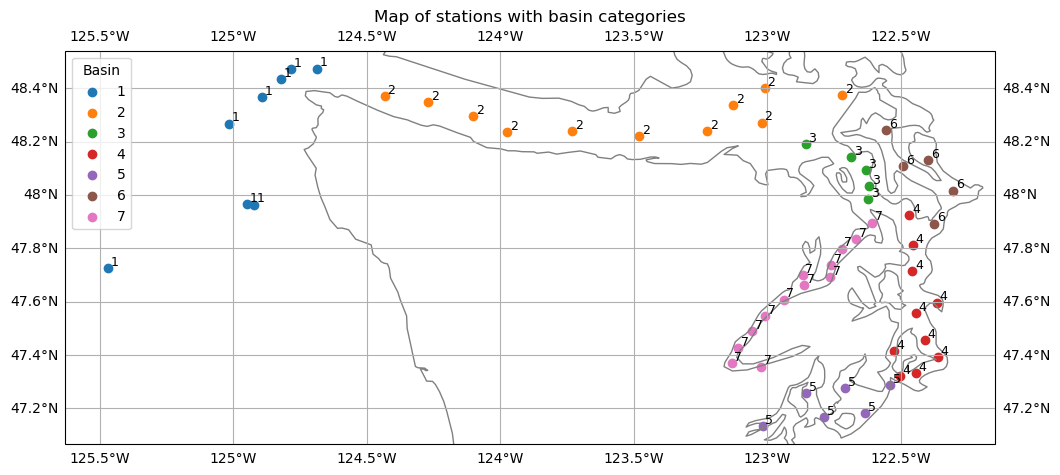

In [307]:
# plot the map of each station showing basin category as label

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# assign lon, lat, labels from the pivot_table
longitudes = pivot_full['LONGITUDE_DEC']
latitudes = pivot_full['LATITUDE_DEC']
labels = pivot_full['basin']

# Assign colors to each category
categories = pivot_full['basin'].unique()
color_map = {category: color for category, color in zip(categories, plt.cm.tab10.colors[:len(categories)])}

# Create a map with coastlines
fig, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Map of stations with basin categories')
ax.coastlines(color='gray')

# plot stations color-coded by basin
for category, color in color_map.items():
    subset = pivot_full[pivot_full['basin'] == category]
    plt.scatter(subset['LONGITUDE_DEC'], subset['LATITUDE_DEC'], label=category, color=color, transform=ccrs.PlateCarree())

# add labels
for lon, lat, label in zip(longitudes, latitudes, labels):
    ax.text(lon + 0.01, lat + 0.01, str(label), fontsize=9, transform=ccrs.PlateCarree())

# Add gridlines and legend
ax.gridlines(draw_labels=True)
ax.legend(title="Basin")

plt.savefig('station_map_with_basins_full_dataset_2008_to_2024.png', 
    dpi=300, bbox_inches='tight')  # Save the frame as an image

# Show the map
plt.show()

In [308]:
# check dtypes to see if the number of missing basins is reduced
dtypes = show_dtypes(df_full)

                              dtype nunique isna_sum
Unnamed: 0                    int64   13223        0
RECORD                        int64   13223        0
EXPOCODE                     object      45        0
CRUISE_ID                    object      62        0
DATE_UTC                     object     264        0
TIME_UTC                     object    9506        0
DATE_LOCAL                   object     258        0
TIME_LOCAL                   object   10069        0
LONGITUDE_DEC               float64    2062        0
LATITUDE_DEC                float64    2055        0
STATION_NO                  float64      58        8
NISKIN_NO                     int64      24        0
NISKIN_NO_FLAG_W              int64       3        0
CTDPRS_DBAR                 float64    4060        0
CTDTMP_DEG_C_ITS90          float64    1112        0
CTDTMP_FLAG_W                 int64       2        0
CTDSAL_PSS78                float64     978       20
CTDSAL_FLAG_W                 int64       3   

### Extract the candidate preditor features from the full oxygen dataset

In [311]:
# extract candidate features from df_full
candidate_features = [
    'RECORD',
    'RECOMMENDED_OXYGEN_MG_L',
    'month',
    'CTDPRS_DBAR',
    'CTDTMP_DEG_C_ITS90',
    'CTDSAL_PSS78',
    'basin'
]
X_full = df_full[candidate_features].dropna()
X_full = X_full.rename(columns={'month':'MONTH_UTC'})
dtypes = show_dtypes(X_full)
print(f"Shape of X_full (nrows,ncols): {X_full.shape}")

                           dtype nunique isna_sum
RECORD                     int64   13182        0
RECOMMENDED_OXYGEN_MG_L  float64    1273        0
MONTH_UTC                  int64      11        0
CTDPRS_DBAR              float64    4043        0
CTDTMP_DEG_C_ITS90       float64    1112        0
CTDSAL_PSS78             float64     978        0
basin                    float64       7        0
Shape of X_full (nrows,ncols): (13182, 7)


### Predicted pH for the full dataset

In [312]:
# preprocess X for each model method
from PyMLR import preprocess_test
X_full_proc_xgb = preprocess_test(X_full, final_output_xgb['preprocess_result'])  
X_full_proc_catboost = preprocess_test(X_full, final_output_catboost['preprocess_result'])  
X_full_proc_svr = preprocess_test(X_full, final_output_svr['preprocess_result'])  
X_full_proc_knn = preprocess_test(X_full, final_output_knn['preprocess_result'])  
X_full_proc_lasso = preprocess_test(X_full, final_output_lasso['preprocess_result'])  
X_full_proc_linear = preprocess_test(X_full, final_output_linear['preprocess_result'])  

In [313]:
# final model for eacn method
model_xgb = final_model_xgb
model_catboost = final_model_catboost
model_svr = final_model_svr
model_knn = final_model_knn
model_lasso = final_model_lasso['LassoLarsBIC']
model_linear = final_model_linear

In [314]:
# final selected features for each method
selected_features_xgb = final_output_xgb['selected_features']
selected_features_catboost = final_output_catboost['selected_features']
selected_features_svr = final_output_svr['selected_features']
selected_features_knn = final_output_knn['selected_features']
selected_features_lasso = final_output_lasso['selected_features']
selected_features_linear = final_output_linear['selected_features']

In [316]:
# predicted pH for the full oxygen dataset from each regression method
df_pred = pd.DataFrame()
df_pred['RECORD'] = X_full['RECORD']
df_pred['pH_pred_xgb'] = model_xgb.predict(X_full_proc_xgb[selected_features_xgb])
df_pred['pH_pred_catboost'] = model_catboost.predict(X_full_proc_catboost[selected_features_catboost])
df_pred['pH_pred_svr'] = model_svr.predict(X_full_proc_svr[selected_features_svr])
df_pred['pH_pred_knn'] = model_knn.predict(X_full_proc_knn[selected_features_knn])
df_pred['pH_pred_lasso'] = model_lasso.predict(X_full_proc_lasso[selected_features_lasso])
df_pred['pH_pred_linear'] = model_linear.predict(X_full_proc_linear[selected_features_linear])

### Merge pH_total_Lueker into df_pred

In [317]:
df_pH_total_Lueker = df[['RECORD','pH_total_Lueker']]
df_pred = df_pred.merge(df_pH_total_Lueker, on='RECORD', how='left', suffixes=('', '_new'))

### Save a csv file with the full oxygen dataset with the added columns of observed and predicted pH

In [318]:
# Merge the predicted pH for each regression method into the full dataset and save as csv
result = df_full.merge(df_pred, on='RECORD', how='left', suffixes=('', '_new'))

# Save the merged full dataset to csv
result.to_csv('SalishCruise_2008to2024_forQC_07232025_basins_with_PyMLR_pH.csv', index=False)

### QQ plot to compare the different methods of predicted pH from the full oxygen dataset

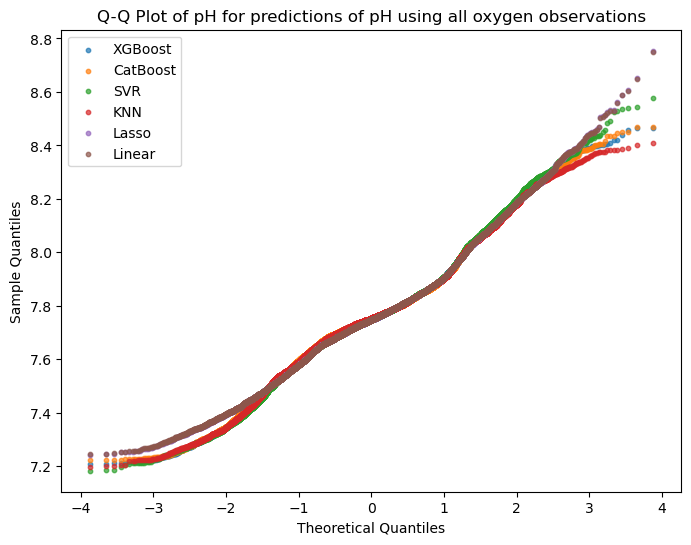

In [320]:
# QQ plot to compare the predicted pH from the full oxygen dataset with the full pH dataset
import scipy.stats as stats

result2 = result[['pH_pred_xgb','pH_pred_catboost','pH_pred_svr','pH_pred_knn','pH_pred_lasso','pH_pred_linear']].dropna()
# data1 = y        # final training data
data2 = result2['pH_pred_xgb']  
data3 = result2['pH_pred_catboost']
data4 = result2['pH_pred_svr']
data5 = result2['pH_pred_knn']
data6 = result2['pH_pred_lasso']
data7 = result2['pH_pred_linear']

# Generate Q-Q plot data for both datasets
# qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")
qq3 = stats.probplot(data3, dist="norm")
qq4 = stats.probplot(data4, dist="norm")
qq5 = stats.probplot(data5, dist="norm")
qq6 = stats.probplot(data6, dist="norm")
qq7 = stats.probplot(data7, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first dataset
# plt.scatter(qq1[0][0], qq1[0][1], marker='s', facecolors='none', edgecolors='black', label='Observations', alpha=0.7)

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color=color_map[1], label='XGBoost', alpha=0.7, s=10)
plt.scatter(qq3[0][0], qq3[0][1], color=color_map[2], label='CatBoost', alpha=0.7, s=10)
plt.scatter(qq4[0][0], qq4[0][1], color=color_map[3], label='SVR', alpha=0.7, s=10)
plt.scatter(qq5[0][0], qq5[0][1], color=color_map[4], label='KNN', alpha=0.7, s=10)
plt.scatter(qq6[0][0], qq6[0][1], color=color_map[5], label='Lasso', alpha=0.7, s=10)
plt.scatter(qq7[0][0], qq7[0][1], color=color_map[6], label='Linear', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of pH for predictions of pH using all oxygen observations')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

# Show the plot
plt.show()